In [120]:
import os
import random
import numpy as np

from collections import namedtuple

from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# TREC - Question Answering (multi-class)

In [121]:
# TREC - Question Answering
# http://cogcomp.cs.illinois.edu/Data/QA/QC/

TREC_Question = namedtuple("TREC_Question", "label question")

trec_train = set()
trec_test = set()

for filename in os.listdir("TREC/"):
    with open("TREC/"+filename,'r', encoding='latin_1') as f_input:
        for line in f_input:
            label, question = line.split(' ', 1)
            label = label.split(':')[0]
            question = TREC_Question(label, question.strip())
            if filename=='TREC_10.label':
                trec_test.add(question)
            else:
                trec_train.add(question)

In [122]:
print("Train Samples: {}".format(len(trec_train)))
print("Test Samples : {}".format(len(trec_test)))
print("Labels       : {}".format({x.label for x in trec_train}))

Train Samples: 5381
Test Samples : 500
Labels       : {'NUM', 'DESC', 'HUM', 'ENTY', 'LOC', 'ABBR'}


In [123]:
# built two lists with sentences and labels
questions_train = [x.question for x in trec_train]
labels_train = [x.label for x in trec_train]

# convert list of tokens/words to indexes
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions_train)
sequences_train = tokenizer.texts_to_sequences(questions_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# get the max sentence lenght, needed for padding
max_input_lenght = max([len(x) for x in sequences_train])
print("Max. sequence lenght: ", max_input_lenght)

# pad all the sequences of indexes to the 'max_input_lenght'
data_train = pad_sequences(sequences_train, maxlen=max_input_lenght, padding='post', truncating='post')

# Encode the labels, each must be a vector with dim = num. of possible labels
le = LabelEncoder()
le.fit(labels_train)
labels_encoded_train = le.transform(labels_train)
categorical_labels_train = to_categorical(labels_encoded_train, num_classes=None)
print('Shape of train data tensor:', data_train.shape)
print('Shape of train label tensor:', categorical_labels_train.shape)

Found 8461 unique tokens.
Max. sequence lenght:  33
Shape of train data tensor: (5381, 33)
Shape of train label tensor: (5381, 6)


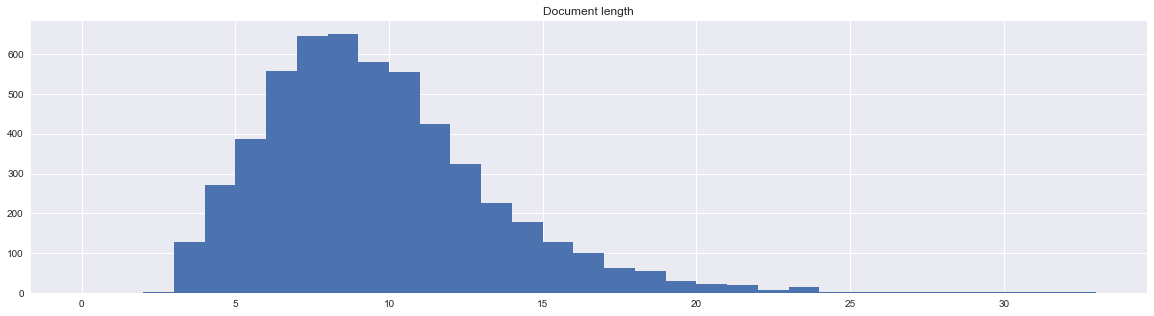

max length: 33 / min length: 2 / mean length: 9 / limit length: 33


In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

result = [len(x) for x in sequences_train]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, max_input_lenght, density=False, range=(0,np.max(result)))
plt.show()

print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result),
                                                                                np.mean(result), max_input_lenght))

## TREC: test data

In [125]:
# pre-process test data
questions_test = [x.question for x in trec_test]
y_test = [x.label for x in trec_test]
sequences_test = tokenizer.texts_to_sequences(questions_test)
x_test = pad_sequences(sequences_test, maxlen=max_input_lenght)

labels_encoded_test = le.transform(y_test)
categorical_labels_test = to_categorical(labels_encoded_test, num_classes=None)
print('Shape of test data tensor:', x_test.shape)
print('Shape of test labels tensor:', categorical_labels_test.shape)

Shape of test data tensor: (500, 33)
Shape of test labels tensor: (500, 6)


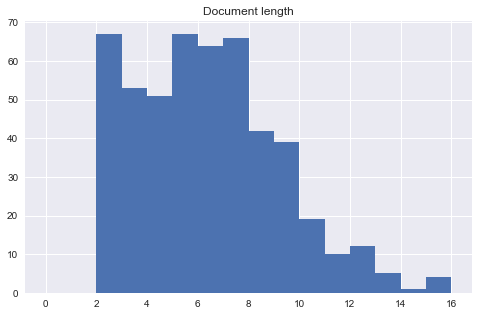

max length: 16 / min length: 2 / mean length: 5 / limit length: 33


In [126]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

result = [len(x) for x in sequences_test]

# Plot histogram
plt.figure(figsize=(8,5))
plt.title('Document length')
plt.hist(result, np.max(result), density=False, range=(0,np.max(result)))
plt.show()

print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result),
                                                                                np.mean(result), max_input_lenght))

In [127]:
from convnets_utils import *

# CNN with random word embeddings

In [128]:
model_1 = get_cnn_rand(300, len(word_index)+1, max_input_lenght, 6, loss='binary_crossentropy')

In [129]:
history = model_1.fit(x=data_train, y=categorical_labels_train, validation_split=0.2, batch_size=50, epochs=10)

/Users/dsbatista/virtual_envs/python37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4304 samples, validate on 1077 samples
Epoch 1/10
4304/4304 [==============================] - 5s 1ms/step - loss: 0.4609 - accuracy: 0.8223 - val_loss: 0.3856 - val_accuracy: 0.8493
Epoch 2/10
4304/4304 [==============================] - 5s 1ms/step - loss: 0.3618 - accuracy: 0.8547 - val_loss: 0.3137 - val_accuracy: 0.8699
Epoch 3/10
4304/4304 [==============================] - 5s 1ms/step - loss: 0.3121 - accuracy: 0.8700 - val_loss: 0.2749 - val_accuracy: 0.8765
Epoch 4/10
4304/4304 [==============================] - 7s 2ms/step - loss: 0.2726 - accuracy: 0.8866 - val_loss: 0.2381 - val_accuracy: 0.9017
Epoch 5/10
4304/4304 [==============================] - 6s 2ms/step - loss: 0.2426 - accuracy: 0.9010 - val_loss: 0.2163 - val_accuracy: 0.9073
Epoch 6/10
4304/4304 [==============================] - 7s 2ms/step - loss: 0.2117 - accuracy: 0.9178 - val_loss: 0.1931 - val_accuracy: 0.9186
Epoch 7/10
4304/4304 [==============================] - 7s 2ms/step - loss: 0.1849 - acc

# Summarize history for accuracy

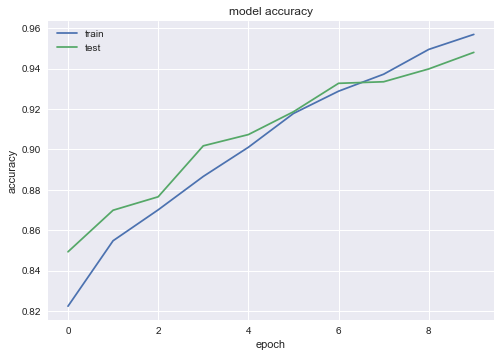

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss

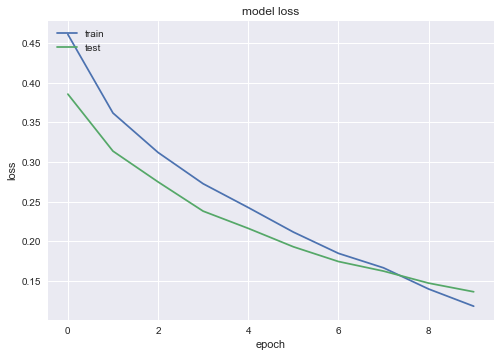

In [131]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [132]:
loss, accuracy = model_1.evaluate(x_test, categorical_labels_test, verbose=0)
accuracy

0.9179999828338623

In [134]:
raw_predictions = model_1.predict(x_test)
class_predictions = [np.argmax(x) for x in raw_predictions]
print(classification_report(y_test, le.inverse_transform(class_predictions)))

              precision    recall  f1-score   support

        ABBR       1.00      0.22      0.36         9
        DESC       0.74      0.22      0.34       138
        ENTY       0.55      0.88      0.68        94
         HUM       0.84      0.86      0.85        65
         LOC       0.91      0.93      0.92        81
         NUM       0.61      0.84      0.70       113

    accuracy                           0.68       500
   macro avg       0.77      0.66      0.64       500
weighted avg       0.72      0.68      0.65       500



---

# CNN with pre-trained static word embeddings

In [135]:
embeddings_index = load_fasttext_embeddings()
embeddings_matrix = create_embeddings_matrix(embeddings_index, word_index, 100)
embedding_layer_static = get_embeddings_layer(embeddings_matrix, 'embedding_layer_static', max_input_lenght, trainable=False)
model_2 = get_cnn_pre_trained_embeddings(embedding_layer_static, max_input_lenght, 6)

Loaded 400000 word vectors.
Matrix shape: (8462, 100)


In [136]:
history = model_2.fit(x=data_train, y=categorical_labels_train, batch_size=50, epochs=10)

Epoch 1/10
5381/5381 [==============================] - 1s 260us/step - loss: 0.4175 - accuracy: 0.8279
Epoch 2/10
5381/5381 [==============================] - 1s 217us/step - loss: 0.2949 - accuracy: 0.8769
Epoch 3/10
5381/5381 [==============================] - 1s 224us/step - loss: 0.2378 - accuracy: 0.9030
Epoch 4/10
5381/5381 [==============================] - 1s 216us/step - loss: 0.2032 - accuracy: 0.9193
Epoch 5/10
5381/5381 [==============================] - 1s 257us/step - loss: 0.1762 - accuracy: 0.9308
Epoch 6/10
5381/5381 [==============================] - 1s 235us/step - loss: 0.1525 - accuracy: 0.9410
Epoch 7/10
5381/5381 [==============================] - 1s 240us/step - loss: 0.1376 - accuracy: 0.9475
Epoch 8/10
5381/5381 [==============================] - 2s 292us/step - loss: 0.1195 - accuracy: 0.9567
Epoch 9/10
5381/5381 [==============================] - 1s 220us/step - loss: 0.1036 - accuracy: 0.9631
Epoch 10/10
5381/5381 [==============================] - 1s 199u

In [137]:
loss, accuracy = model_2.evaluate(x_test, categorical_labels_test, verbose=0)
accuracy

0.8963333368301392

In [138]:
raw_predictions = model_2.predict(x_test)
class_predictions = [np.argmax(x) for x in raw_predictions]
print(classification_report(y_test, le.inverse_transform(class_predictions)))

              precision    recall  f1-score   support

        ABBR       1.00      0.56      0.71         9
        DESC       0.57      0.09      0.15       138
        ENTY       0.32      0.89      0.47        94
         HUM       0.94      0.69      0.80        65
         LOC       0.75      0.73      0.74        81
         NUM       0.98      0.71      0.82       113

    accuracy                           0.57       500
   macro avg       0.76      0.61      0.61       500
weighted avg       0.70      0.57      0.55       500



# CNN with pre-trained dynamic word embeddings

In [139]:
embedding_layer_dynamic = get_embeddings_layer(embeddings_matrix, 'embedding_layer_dynamic', max_input_lenght, trainable=True)
model_3 = get_cnn_pre_trained_embeddings(embedding_layer_dynamic, max_input_lenght, 6)

In [140]:
history = model_3.fit(x=data_train, y=categorical_labels_train, batch_size=50, epochs=10)

/Users/dsbatista/virtual_envs/python37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
5381/5381 [==============================] - 3s 491us/step - loss: 0.4042 - accuracy: 0.8344
Epoch 2/10
5381/5381 [==============================] - 2s 434us/step - loss: 0.2641 - accuracy: 0.8916
Epoch 3/10
5381/5381 [==============================] - 2s 440us/step - loss: 0.2045 - accuracy: 0.9175
Epoch 4/10
5381/5381 [==============================] - 2s 437us/step - loss: 0.1554 - accuracy: 0.9412
Epoch 5/10
5381/5381 [==============================] - 3s 551us/step - loss: 0.1220 - accuracy: 0.9552
Epoch 6/10
5381/5381 [==============================] - 3s 511us/step - loss: 0.0878 - accuracy: 0.9700
Epoch 7/10
5381/5381 [==============================] - 2s 435us/step - loss: 0.0664 - accuracy: 0.9788
Epoch 8/10
5381/5381 [==============================] - 3s 467us/step - loss: 0.0493 - accuracy: 0.9846
Epoch 9/10
5381/5381 [==============================] - 3s 550us/step - loss: 0.0371 - accuracy: 0.9905
Epoch 10/10
5381/5381 [==============================] - 3s 647u

In [141]:
loss, accuracy = model_3.evaluate(x_test, categorical_labels_test, verbose=0)
accuracy

0.9193333387374878

In [142]:
raw_predictions = model_3.predict(x_test)
class_predictions = [np.argmax(x) for x in raw_predictions]
print(classification_report(y_test, le.inverse_transform(class_predictions)))

              precision    recall  f1-score   support

        ABBR       0.75      0.67      0.71         9
        DESC       0.76      0.22      0.35       138
        ENTY       0.39      0.82      0.52        94
         HUM       0.94      0.77      0.85        65
         LOC       0.74      0.90      0.82        81
         NUM       0.96      0.85      0.90       113

    accuracy                           0.67       500
   macro avg       0.76      0.71      0.69       500
weighted avg       0.75      0.67      0.65       500



# CNN multichanell with pre-trained dynamic and static word embeddings

In [143]:
model_4 = get_cnn_multichannel(embedding_layer_static, embedding_layer_dynamic, max_input_lenght, 6)

In [144]:
history = model_4.fit(x=[data_train, data_train], y=categorical_labels_train, batch_size=50, epochs=10)

/Users/dsbatista/virtual_envs/python37/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
5381/5381 [==============================] - 5s 849us/step - loss: 0.3729 - accuracy: 0.8503
Epoch 2/10
5381/5381 [==============================] - 5s 891us/step - loss: 0.1572 - accuracy: 0.9410
Epoch 3/10
5381/5381 [==============================] - 5s 893us/step - loss: 0.0900 - accuracy: 0.9702
Epoch 4/10
5381/5381 [==============================] - 5s 856us/step - loss: 0.0549 - accuracy: 0.9828
Epoch 5/10
5381/5381 [==============================] - 4s 833us/step - loss: 0.0345 - accuracy: 0.9902
Epoch 6/10
5381/5381 [==============================] - 4s 768us/step - loss: 0.0211 - accuracy: 0.9950
Epoch 7/10
5381/5381 [==============================] - 4s 807us/step - loss: 0.0158 - accuracy: 0.9967
Epoch 8/10
5381/5381 [==============================] - 4s 702us/step - loss: 0.0119 - accuracy: 0.9972
Epoch 9/10
5381/5381 [==============================] - 4s 690us/step - loss: 0.0088 - accuracy: 0.9983
Epoch 10/10
5381/5381 [==============================] - 4s 760u

In [145]:
loss, accuracy = model_4.evaluate(x=[x_test,x_test], y=categorical_labels_test, verbose=0)
accuracy

0.921333372592926

In [146]:
raw_predictions = model_4.predict([x_test, x_test])
class_predictions = [np.argmax(x) for x in raw_predictions]
print(classification_report(y_test, le.inverse_transform(class_predictions)))

              precision    recall  f1-score   support

        ABBR       0.88      0.78      0.82         9
        DESC       0.64      0.26      0.37       138
        ENTY       0.38      0.79      0.51        94
         HUM       0.84      0.83      0.84        65
         LOC       0.87      0.89      0.88        81
         NUM       1.00      0.81      0.90       113

    accuracy                           0.67       500
   macro avg       0.77      0.73      0.72       500
weighted avg       0.74      0.67      0.67       500

